In [16]:
import geopandas as gpd
import pandas as pd
import numpy as np
import rasterio
from rasterio.mask import mask
from shapely.geometry import shape, mapping
import matplotlib.pyplot as plt
from tqdm import tqdm
import yaml
import os

# Load configuration
with open('../../config.yaml', 'r') as file:
    config = yaml.safe_load(file)

def resolve_path(relative_path):
    return os.path.join(config['base_path'], relative_path)

In [17]:
CPIS_path = resolve_path(config['Combined_CPIS_shp_path'])
Arid_Cropland_path = resolve_path(config['Arid_Cropland_tif_path'])

CPIS_gdf = gpd.read_file(CPIS_path)

with rasterio.open(Arid_Cropland_path) as src:
    Arid_Cropland_array = src.read(1)
    Arid_Cropland_transform = src.transform
    Arid_cropland_crs = src.crs

# Make sure the coordinate systems are matching
CPIS_gdf.set_crs(epsg=4326, inplace = True)

print(CPIS_gdf.crs)
print(Arid_cropland_crs)

KeyboardInterrupt: 

In [ ]:
# Function to check if a geometry is within the raster bounds and has a value of 1
def check_within_raster(geometry, raster_array, raster_transform):
    masked, _ = mask(rasterio.open(Arid_Cropland_path), [mapping(geometry)], crop=True)
    return np.any(masked == 1)

# Apply the function to each geometry in the CPIS GeoDataFrame with a progress bar
tqdm.pandas(desc="Checking geometries")
CPIS_gdf['within_arid'] = CPIS_gdf.geometry.progress_apply(lambda x: check_within_raster(x, Arid_Cropland_array, Arid_Cropland_transform))

# Check if any geometry is outside the arid area
outside_cpis = CPIS_gdf[~CPIS_gdf['within_arid']].shape[0] > 0

# Print the result
print("Yes" if outside_cpis else "No")

Checking geometries: 100%|██████████| 32364/32364 [06:28<00:00, 83.34it/s] 

Yes


In [ ]:
import geopandas as gpd
import numpy as np
import rasterio
from rasterio.mask import mask
from shapely.geometry import mapping
import yaml
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

# Load configuration
with open('../../config.yaml', 'r') as file:
    config = yaml.safe_load(file)

def resolve_path(relative_path):
    return os.path.join(config['base_path'], relative_path)

CPIS_path = resolve_path(config['Combined_CPIS_shp_path'])
Arid_Cropland_path = resolve_path(config['Arid_Cropland_tif_path'])

# Load the CPIS shapefile
CPIS_gdf = gpd.read_file(CPIS_path)

# Load the Arid Cropland raster
with rasterio.open(Arid_Cropland_path) as src:
    Arid_Cropland_array = src.read(1)
    Arid_Cropland_transform = src.transform

# Make sure the coordinate systems are matching
CPIS_gdf.set_crs(epsg=4326, inplace=True)

# Function to check if a geometry is within the raster bounds and has a value of 1
def check_within_raster(geometry, raster_array, raster_transform):
    masked, _ = mask(rasterio.open(Arid_Cropland_path), [mapping(geometry)], crop=True)
    return np.any(masked == 1)

# Apply the function to each geometry in the CPIS GeoDataFrame with a progress bar
tqdm.pandas(desc="Checking geometries")
CPIS_gdf['within_arid'] = CPIS_gdf.geometry.progress_apply(lambda x: check_within_raster(x, Arid_Cropland_array, Arid_Cropland_transform))

# Filter out geometries that are not within the arid area
outside_cpis_gdf = CPIS_gdf[~CPIS_gdf['within_arid']]

# Check the amount of data outside the arid cropland
outside_count = outside_cpis_gdf.shape[0]

# Print the result
print(f"Number of CPIS geometries outside the arid cropland: {outside_count}")

# Save the result to a new shapefile
#outside_cpis_gdf.to_file(resolve_path(config['Outside_CPIS_shp_path']))


Checking geometries: 100%|██████████| 32364/32364 [06:28<00:00, 83.38it/s] 

Number of CPIS geometries outside the arid cropland: 32275


KeyError: 'Outside_CPIS_shp_path'

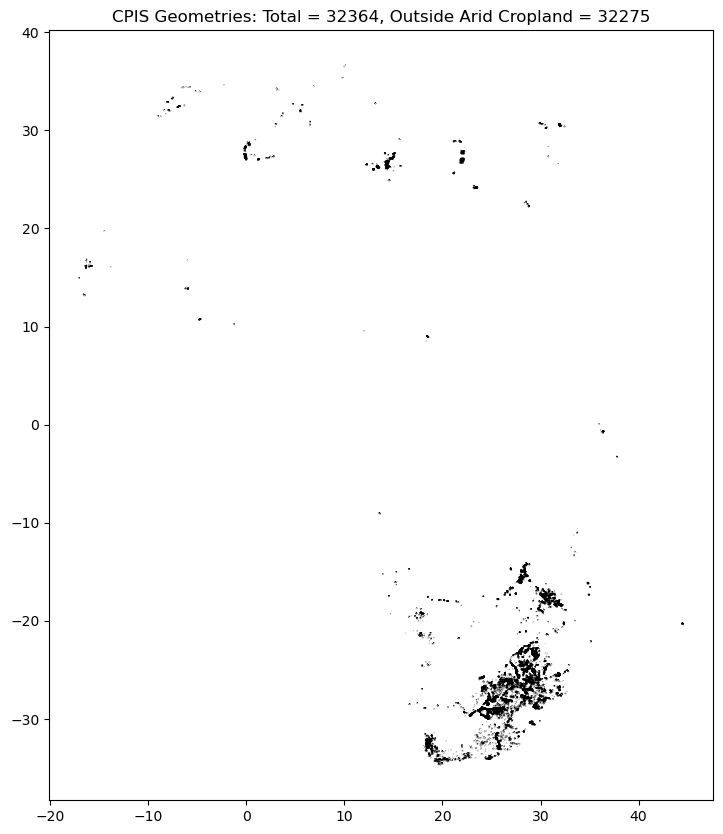

In [ ]:

# Plot the result
base = CPIS_gdf.plot(color='blue', edgecolor='black', alpha=0.5, figsize=(10, 10))
outside_cpis_gdf.plot(ax=base, color='red', edgecolor='black')
plt.title(f"CPIS Geometries: Total = {len(CPIS_gdf)}, Outside Arid Cropland = {outside_count}")
plt.show()


In [ ]:
import geopandas as gpd
import numpy as np
import rasterio
from rasterio.mask import mask
from shapely.geometry import mapping
from shapely.geometry import Point
import yaml
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

# Load configuration
with open('../../config.yaml', 'r') as file:
    config = yaml.safe_load(file)

def resolve_path(relative_path):
    return os.path.join(config['base_path'], relative_path)

CPIS_path = resolve_path(config['Combined_CPIS_shp_path'])
Arid_Cropland_path = resolve_path(config['Arid_Cropland_tif_path'])

# Load the CPIS shapefile
CPIS_gdf = gpd.read_file(CPIS_path)

# Load the Arid Cropland raster
with rasterio.open(Arid_Cropland_path) as src:
    Arid_Cropland_array = src.read(1)
    Arid_Cropland_transform = src.transform

# Make sure the coordinate systems are matching
CPIS_gdf.set_crs(epsg=4326, inplace=True)

# Function to check if the centroid of a geometry is within the raster bounds and has a value of 1
def check_centroid_within_raster(geometry, raster_array, raster_transform):
    centroid = geometry.centroid
    masked, _ = mask(rasterio.open(Arid_Cropland_path), [mapping(centroid)], crop=True)
    return np.any(masked == 1)

# Apply the function to each geometry in the CPIS GeoDataFrame with a progress bar
tqdm.pandas(desc="Checking centroids")
CPIS_gdf['centroid_within_arid'] = CPIS_gdf.geometry.progress_apply(lambda x: check_centroid_within_raster(x, Arid_Cropland_array, Arid_Cropland_transform))

# Filter out geometries whose centroids are not within the arid area
inside_cpis_gdf = CPIS_gdf[CPIS_gdf['centroid_within_arid']]

# Check the amount of data inside the arid cropland
inside_count = inside_cpis_gdf.shape[0]

# Print the result
print(f"Number of CPIS geometries inside the arid cropland: {inside_count}")

# Save the result to a new shapefile
#inside_cpis_gdf.to_file(resolve_path(config['Inside_CPIS_shp_path']))


Checking centroids: 100%|██████████| 32364/32364 [05:57<00:00, 90.58it/s] 


Number of CPIS geometries inside the arid cropland: 27715


KeyError: 'Inside_CPIS_shp_path'

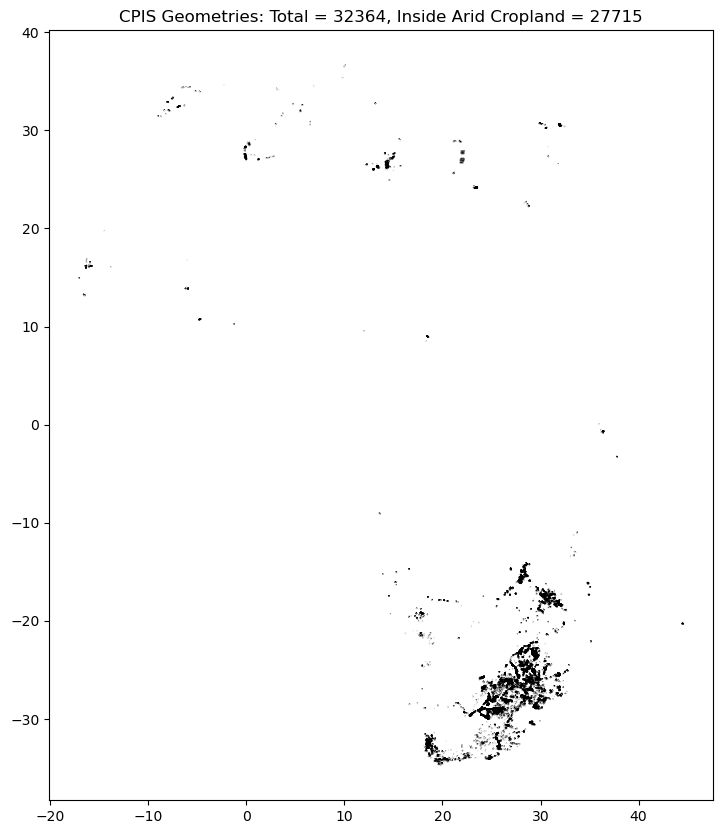

In [ ]:

# Plot the result
base = CPIS_gdf.plot(color='blue', edgecolor='black', alpha=0.5, figsize=(10, 10))
inside_cpis_gdf.plot(ax=base, color='green', edgecolor='black')
plt.title(f"CPIS Geometries: Total = {len(CPIS_gdf)}, Inside Arid Cropland = {inside_count}")
plt.show()


Checking centroids: 100%|██████████| 32364/32364 [00:12<00:00, 2553.40it/s]


Number of CPIS geometries inside the Arid Cropland: 32258


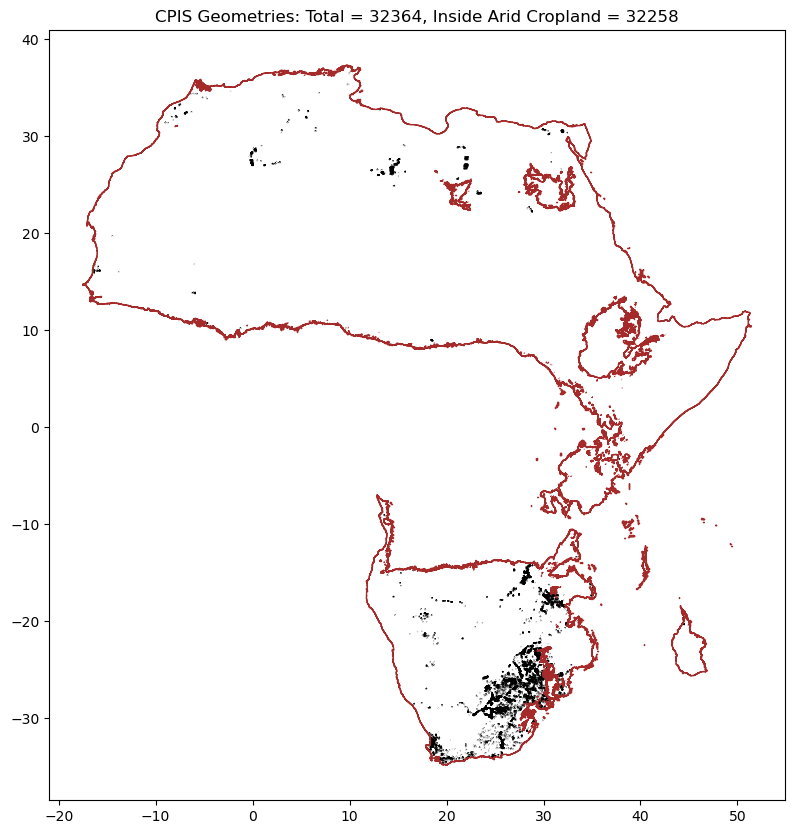

In [19]:
import geopandas as gpd
from shapely.geometry import Point
import yaml
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

# Load configuration
with open('../../config.yaml', 'r') as file:
    config = yaml.safe_load(file)

def resolve_path(relative_path):
    return os.path.join(config['base_path'], relative_path)

CPIS_path = resolve_path(config['Combined_CPIS_shp_path'])
Arid_Cropland_path = resolve_path(config['Africa_all_shp_path'])  # Path to Arid Cropland shapefile

# Load the CPIS shapefile
CPIS_gdf = gpd.read_file(CPIS_path)

# Load the Arid Cropland shapefile
Arid_Cropland_gdf = gpd.read_file(Arid_Cropland_path)

# Make sure the coordinate systems are matching
CPIS_gdf.set_crs(epsg=4326, inplace=True)
Arid_Cropland_gdf.set_crs(epsg=4326, inplace=True)

# Function to check if the centroid of a geometry intersects with any features in the Arid Cropland shapefile
def check_centroid_intersect(geometry, arid_cropland_gdf):
    centroid = geometry.centroid
    return arid_cropland_gdf.geometry.intersects(centroid).any()

# Apply the function to each geometry in the CPIS GeoDataFrame with a progress bar
tqdm.pandas(desc="Checking centroids")
CPIS_gdf['centroid_in_arid_cropland'] = CPIS_gdf.geometry.progress_apply(lambda x: check_centroid_intersect(x, Arid_Cropland_gdf))

# Filter out geometries whose centroids do not intersect with the Arid Cropland
inside_cpis_gdf = CPIS_gdf[CPIS_gdf['centroid_in_arid_cropland']]

# Check the amount of data inside the Arid Cropland
inside_count = inside_cpis_gdf.shape[0]

# Print the result
print(f"Number of CPIS geometries inside the Arid Cropland: {inside_count}")

# Save the result to a new shapefile
#inside_cpis_gdf.to_file(resolve_path(config['Inside_CPIS_shp_path']))

# Plot the result
base = CPIS_gdf.plot(color='blue', edgecolor='black', alpha=0.5, figsize=(10, 10))
inside_cpis_gdf.plot(ax=base, color='green', edgecolor='black')
Arid_Cropland_gdf.plot(ax=base, color='none', edgecolor='brown')  # Add Arid Cropland boundaries for reference
plt.title(f"CPIS Geometries: Total = {len(CPIS_gdf)}, Inside Arid Cropland = {inside_count}")
plt.show()


In [24]:
import geopandas as gpd
import numpy as np
import yaml
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

# Load configuration
with open('../../config.yaml', 'r') as file:
    config = yaml.safe_load(file)

def resolve_path(relative_path):
    return os.path.join(config['base_path'], relative_path)

CPIS_path = resolve_path(config['Combined_CPIS_shp_path'])
Arid_Cropland_path = resolve_path(config['Africa_all_shp_path'])  # Change to shapefile path

# Load the CPIS shapefile
CPIS_gdf = gpd.read_file(CPIS_path)

# Load the Arid Cropland shapefile
Arid_Cropland_gdf = gpd.read_file(Arid_Cropland_path)

# Make sure the coordinate systems are matching
CPIS_gdf.set_crs(epsg=4326, inplace=True)
Arid_Cropland_gdf.set_crs(epsg=4326, inplace=True)

# Define a suitable projected CRS for Africa-wide analysis
projected_crs = 'EPSG:32734'  # Africa Albers Equal Area Conic

# Reproject both GeoDataFrames to the chosen projected CRS
CPIS_gdf = CPIS_gdf.to_crs(projected_crs)
Arid_Cropland_gdf = Arid_Cropland_gdf.to_crs(projected_crs)

# Function to check if the centroid of a geometry is within the arid cropland area
def check_within_arid_cropland(centroid, arid_cropland_gdf):
    return arid_cropland_gdf.contains(centroid).any()

# Apply the function to each CPIS polygon
tqdm.pandas(desc="Checking centroids within arid cropland")
CPIS_gdf['centroid'] = CPIS_gdf.centroid
CPIS_gdf['within_arid'] = CPIS_gdf['centroid'].progress_apply(lambda x: check_within_arid_cropland(x, Arid_Cropland_gdf))

# Filter out geometries that are not within the arid cropland
outside_cpis_gdf = CPIS_gdf[~CPIS_gdf['within_arid']]

# Check the amount of data outside the arid cropland
outside_count = outside_cpis_gdf.shape[0]

# Print the result
print(f"Number of CPIS geometries outside the arid cropland: {outside_count}")

# Save the result to a new shapefile
outside_cpis_gdf.to_file(resolve_path(config['Outside_CPIS_shp_path']))

# Plot the result
base = CPIS_gdf.plot(color='blue', edgecolor='black', alpha=0.5, figsize=(10, 10))
Arid_Cropland_gdf.plot(ax=base, color='green', edgecolor='black', alpha=0.3)
outside_cpis_gdf.plot(ax=base, color='red', edgecolor='black')
plt.title(f"CPIS Geometries: Total = {len(CPIS_gdf)}, Outside Arid Cropland = {outside_count}")
plt.show()


Checking centroids within arid cropland: 100%|██████████| 32364/32364 [25:36<00:00, 21.06it/s]

Number of CPIS geometries outside the arid cropland: 106


KeyError: 'Outside_CPIS_shp_path'